## Imports

In [98]:
from collections import Counter
from collections import defaultdict
import math
import numpy as np
import codecs
import tqdm
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from utils import iter_smiles
import trie_funcs as tf
from ape_tokenizer import APETokenizer
from SmilesPE.tokenizer import SPE_Tokenizer

## Load Pre-Trained Tokenizers

In [47]:
SLICE = "data/pubchem_100K.parquet"
TRIE_FILE = "trie_pubchem100K.pkl"
APE_DIR = "ape_pubchem100K"
SPE_FILE = "spe_pubchem100K.txt"

In [52]:
ape = APETokenizer.from_pretrained(APE_DIR)
trie_state = tf.load_state(TRIE_FILE)
spe_vocab = codecs.open("./spe_pubchem100K.txt")
spe = SPE_Tokenizer(spe_vocab)

## Helper Functions

In [49]:
def sum_tokens_and_chars(smiles_iter, token_fn):
    total_tokens = 0
    total_chars = 0

    for smi in smiles_iter:
        total_tokens += token_fn(smi)
        total_chars += len(smi)

    return total_tokens, total_chars


def mean_len(generator, fn, desc):
    tot = n = 0
    for s in tqdm.tqdm(generator, desc=desc):
        tot += fn(s)
        n += 1
    return tot / n


def var_len(generator, fn, desc, mean):
    tot = n = 0
    for s in tqdm.tqdm(generator, desc=desc):
        tot += (fn(s) - mean) ** 2
        n += 1
    return tot / n

## Compute Fertility, Mean, Variance, and Normalized Entropy

In [94]:
def compute_spe_metrics(smiles_list, tokenizer):
    # tokenizer MUST be of type SPETokenizer
    spe_avg = mean_len(iter_smiles(smiles_list),
                       lambda s: len(tokenizer.tokenize(s).split(" ")),
                       "SPE  ")

    total_tokens, total_chars = sum_tokens_and_chars(
        iter_smiles(smiles_list), lambda s: len(tokenizer.tokenize(s).split(" "))
    )
    
    fertility = total_tokens / total_chars

    spe_var = var_len(iter_smiles(smiles_list),
                      lambda s: len(tokenizer.tokenize(s).split(" ")),
                      "SPE variance  ",
                      spe_avg)

    return fertility, spe_avg, spe_var


def compute_trie_metrics(smiles_list, tokenizer):
    # tokenizer MUST be of type trie_state
    trie_avg = mean_len(iter_smiles(smiles_list),
                        lambda s: tf.compress_and_len(s, tokenizer),
                        "Trie ")
    
    total_tokens, total_chars = sum_tokens_and_chars(
        iter_smiles(smiles_list), lambda s: tf.compress_and_len(s, tokenizer)
    )

    fertility = total_tokens / total_chars
    
    trie_var = var_len(iter_smiles(smiles_list),
                        lambda s: tf.compress_and_len(s, tokenizer),
                        "Trie variance  ",
                        trie_avg)
    
    return fertility, trie_avg, trie_var


def compute_ape_metrics(smiles_list, tokenizer):
    # tokenizer MUST be of type APETokenizer
    ape_avg = mean_len(iter_smiles(smiles_list),
                       lambda s: len(ape.encode(s)),
                       "APE  ")
    
    total_tokens, total_chars = sum_tokens_and_chars(
        iter_smiles(smiles_list), lambda s: len(ape.encode(s))
    )

    fertility = total_tokens / total_chars
    
    ape_var = var_len(iter_smiles(smiles_list),
                       lambda s: len(ape.encode(s)),
                       "APE variance  ",
                       ape_avg)
    
    return fertility, ape_avg, ape_var


def compute_spe_normalized_entropy(smiles_list, spe_tokenizer):
    """
    smiles_list: list of smiles strings
    spe_tokenizer: an instance of SPE_Tokenizer
    """
    token_freq = Counter()
    total_tokens = 0

    for smi in smiles_list:
        toks = spe_tokenizer.tokenize(smi).split(" ")
        token_freq.update(toks)
        total_tokens += len(toks)

    # Use only the tokens you actually saw
    vocab_size = len(token_freq)

    # Shannon entropy
    entropy = -sum((cnt/total_tokens) * math.log2(cnt/total_tokens)
                   for cnt in token_freq.values())

    # Normalize by log₂(observed_vocab_size)
    return entropy / math.log2(vocab_size)


def compute_ape_normalized_entropy(smiles_list, ape_tokenizer):
    """
    smiles_list: list of smiles strings
    ape_tokenizer: an instance of APE_Tokenizer
    """
    token_freq = Counter()
    total_tokens = 0

    for smi in smiles_list:
        toks = ape_tokenizer.encode(smi)
        token_freq.update(toks)
        total_tokens += len(toks)

    # Use only the tokens you actually saw
    vocab_size = len(token_freq)

    # Shannon entropy
    entropy = -sum((cnt/total_tokens) * math.log2(cnt/total_tokens)
                   for cnt in token_freq.values())

    # Normalize by log₂(observed_vocab_size)
    return entropy / math.log2(vocab_size)


def compute_trie_normalized_entropy(smiles_list, trie_tokenizer):
    """
    smiles_list: list of smiles strings
    trie_tokenizer: an instance of trie_Tokenizer
    """
    token_freq = Counter()
    total_tokens = 0

    for smi in smiles_list:
        base = tf.tokenize(smi)  # list of atomic tokens
        toks = tf.compress(base, trie_tokenizer.replace_root)
        token_freq.update(toks)
        total_tokens += len(toks)

    # Use only the tokens you actually saw
    vocab_size = len(token_freq)

    # Shannon entropy
    entropy = -sum((cnt/total_tokens) * math.log2(cnt/total_tokens)
                   for cnt in token_freq.values())

    # Normalize by log₂(observed_vocab_size)
    return entropy / math.log2(vocab_size)


In [99]:
spe_start = time.time()
spe_fert, spe_avg, spe_var = compute_spe_metrics(SLICE, spe)
spe_ent  = compute_spe_normalized_entropy(SLICE, spe)
spe_end = time.time()

trie_start = time.time()
trie_fert, trie_avg, trie_var = compute_trie_metrics(SLICE, trie_state)
trie_ent  = compute_trie_normalized_entropy(SLICE, trie_state)
trie_end = time.time()

ape_start = time.time()
ape_fert, ape_avg, ape_var = compute_ape_metrics(SLICE, ape)
ape_ent  = compute_ape_normalized_entropy(SLICE, ape)
ape_end = time.time()


SPE  : 100000it [00:00, 356169.98it/s]
SPE variance  : 100000it [00:00, 445960.60it/s]
Trie : 100000it [00:00, 100576.92it/s]
Trie variance  : 100000it [00:00, 108013.73it/s]
APE  : 100000it [00:01, 50995.38it/s]
APE variance  : 100000it [00:02, 49493.83it/s]


## Compare Metrics

In [101]:
df = pd.DataFrame({
    "Tokenizer": ["SPE", "Trie", "APE"],
    "Fertility": [spe_fert, trie_fert, ape_fert],
    "Mean": [spe_avg, trie_avg, ape_avg],
    "Variance": [spe_var, trie_var, ape_var],
    "Normalized Entropy": [spe_ent, trie_ent, ape_ent],
    "Time" : [spe_end - spe_start, trie_end - trie_start, ape_end - ape_start]
})

df.style.format({"Fertility": "{:.4f}", "Mean": "{:.2f}", "Variance": "{:.2f}", "Time" : "{:.2f}"})


,Tokenizer,Fertility,Mean,Variance,Normalized Entropy,Time
0,SPE,0.2788,12.38,42.39,0.972118,0.72
1,Trie,0.1014,4.50,5.49,0.960964,2.80
2,APE,0.1576,7.00,13.28,0.437155,5.95


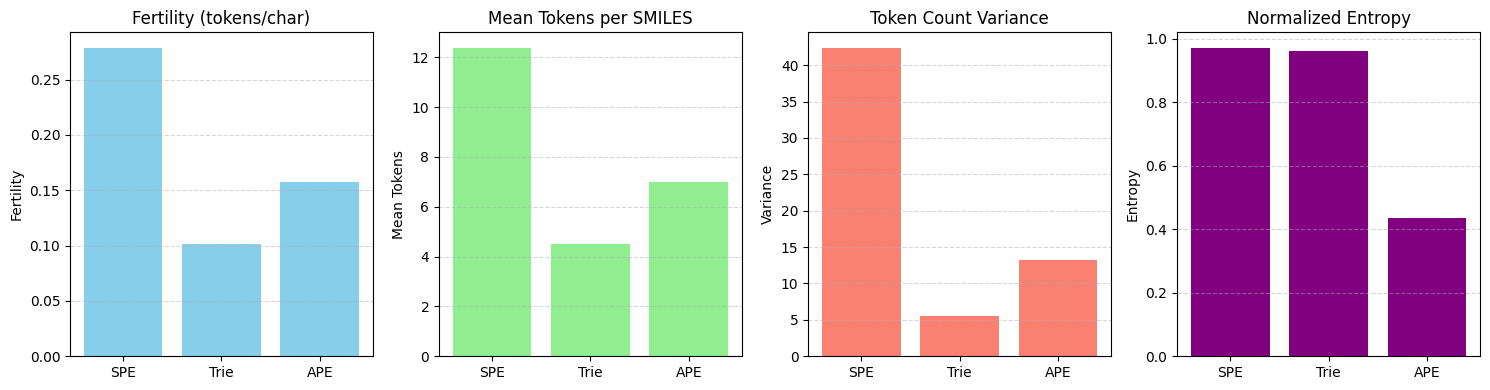

In [104]:
# Labels and values
tokenizers = ["SPE", "Trie", "APE"]

fertilities = df["Fertility"]
means = df["Mean"]
variances = df["Variance"]
entropies = df["Normalized Entropy"]

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

# Fertility
axs[0].bar(tokenizers, fertilities, color="skyblue")
axs[0].set_title("Fertility (tokens/char)")
axs[0].set_ylabel("Fertility")

# Mean
axs[1].bar(tokenizers, means, color="lightgreen")
axs[1].set_title("Mean Tokens per SMILES")
axs[1].set_ylabel("Mean Tokens")

# Variance
axs[2].bar(tokenizers, variances, color="salmon")
axs[2].set_title("Token Count Variance")
axs[2].set_ylabel("Variance")

# Normalized Entropy
axs[3].bar(tokenizers, entropies, color="purple")
axs[3].set_title("Normalized Entropy")
axs[3].set_ylabel("Entropy")

# Clean layout
for ax in axs:
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


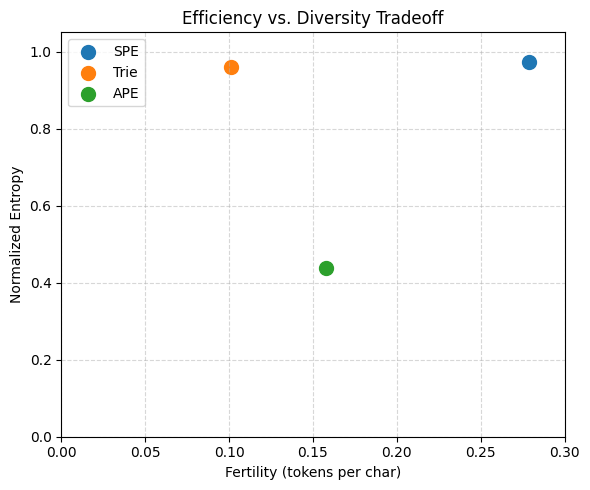

In [105]:
import matplotlib.pyplot as plt

# Your data
tokenizers = ["SPE", "Trie", "APE"]
fertility = [0.2788, 0.1014, 0.1576]
entropy = [0.9721, 0.9610, 0.4372]

# Plot
plt.figure(figsize=(6, 5))
for i in range(len(tokenizers)):
    plt.scatter(fertility[i], entropy[i], label=tokenizers[i], s=100)

plt.xlabel("Fertility (tokens per char)")
plt.ylabel("Normalized Entropy")
plt.title("Efficiency vs. Diversity Tradeoff")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.xlim(0, 0.3)
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()


| **APE**   | Moderate efficiency, low diversity (good for simple compression but may overfit).                                     |
| --------- | --------------------------------------------------------------------------------------------------------------------- |
| **SPE**   | High diversity and oversegmentation — useful for maximizing vocabulary expressiveness.                                |
| **Trie**  | Best overall balance — lowest fertility, low variance, high entropy. Ideal for **efficient and stable** tokenization. |